In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/png.zip

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam

In [ ]:
def data_loader(folder_dir):
    image_dataset = []
    for images in os.listdir(folder_dir):
        image = cv2.imread(folder_dir+'/'+images, 1)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        image = Image.fromarray(image)
        image = np.array(image)
        image_dataset.append(image)
    return image_dataset

In [ ]:
image_dataset = data_loader("/content/png/train/")

In [ ]:
mask_dataset = data_loader("/content/png/train_labels/")

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(image_dataset.shape)
print(mask_dataset.shape)

(125, 256, 256, 3)
(125, 256, 256, 3)


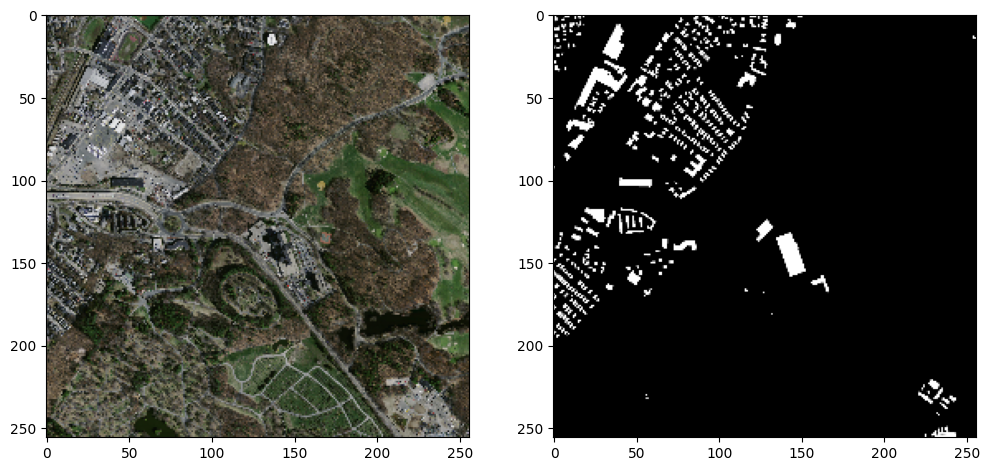

In [ ]:
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [ ]:
mask_labels = pd.read_csv('/content/drive/MyDrive/label_class_dict.csv')
mask_labels

,name,r,g,b
0,background,0,0,0
1,building,255,255,255


In [ ]:
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]
    return label_seg

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels)
    labels.append(label)

In [ ]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0],cmap="gray")
plt.show()

In [ ]:
n_classes = len(np.unique(labels))
print(n_classes)

2


In [ ]:
labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 256, 256, 3)
(25, 256, 256, 3)
(100, 256, 256, 2)
(25, 256, 256, 2)


In [ ]:
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input, Dropout

In [ ]:
def Conv2D_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
              kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
               kernel_initializer='he_normal', padding='same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
from keras import Model

In [ ]:
def unet(input_image, n_filters=16, kernel_size=3, dropout=0.1, batchnorm=True):
    #Encoder
    c1 = Conv2D_block(input_image, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)
    p1 = MaxPooling2D((2,2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = Conv2D_block(p1, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = Conv2D_block(p2, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = Conv2D_block(p3, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = Conv2D_block(p4, n_filters * 16, kernel_size = kernel_size, batchnorm = batchnorm)

    # Decoder
    u6 = Conv2DTranspose(n_filters * 8, (kernel_size, kernel_size), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = Conv2D_block(u6, n_filters * 8, kernel_size = kernel_size, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (kernel_size, kernel_size), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = Conv2D_block(u7, n_filters * 4, kernel_size = kernel_size, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (kernel_size, kernel_size), strides=(2,2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = Conv2D_block(u8, n_filters * 2, kernel_size = kernel_size, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters, (kernel_size, kernel_size), strides=(2,2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = Conv2D_block(u9, n_filters, kernel_size = kernel_size, batchnorm = batchnorm)

    output = Conv2D(n_classes, (1,1), activation='sigmoid')(c9)
    model = Model(inputs=[input_image], outputs=[output])
    return model

In [ ]:
image_height = 256
image_width = 256

In [ ]:
input_img = Input((image_height, image_width, 3), name='img')

In [ ]:
model = unet(input_img, n_filters=16, kernel_size=3, dropout=0.01, batchnorm=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, batch_size=16, epochs=95, validation_data=(X_test, y_test))

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

1/1 [==============================] - 3s 3s/step


In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number, :, :, 0]
predicted_img = y_pred_binary[test_img_number, :, :, 0]

In [ ]:
ground_truth = 1 - ground_truth
predicted_img = 1 - predicted_img

In [ ]:
plt.figure(figsize=(16, 12))
plt.subplot(231)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Test Label')
plt.imshow(ground_truth,cmap="gray")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap="gray")
plt.show()

In [ ]:
img = cv2.imread('/content/drive/MyDrive/tilotama.png')
test_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_prepr = cv2.resize(test_image, (256,256))
image_prepr = np.expand_dims(image_prepr, axis=0)
predictions = model.predict(image_prepr)

1/1 [==============================] - 1s 679ms/step


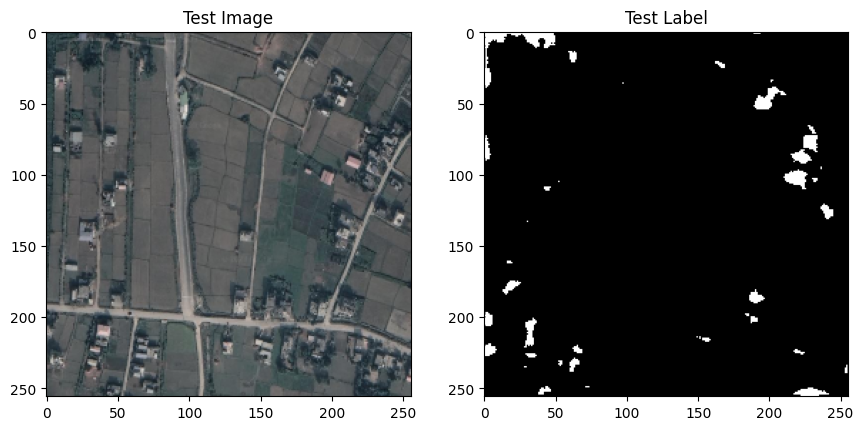

In [ ]:
predicted_mask = np.argmax(predictions, axis=-1)
predicted_maskk = predicted_mask[0]
image = image_prepr[0]
image = image.reshape((256, 256, 3))
plt.figure(figsize=(16, 12))
plt.subplot(235)
plt.title('Test Image')
plt.imshow(image)
plt.subplot(236)
plt.title('Test Label')
plt.imshow(predicted_maskk,cmap="gray")
plt.show()

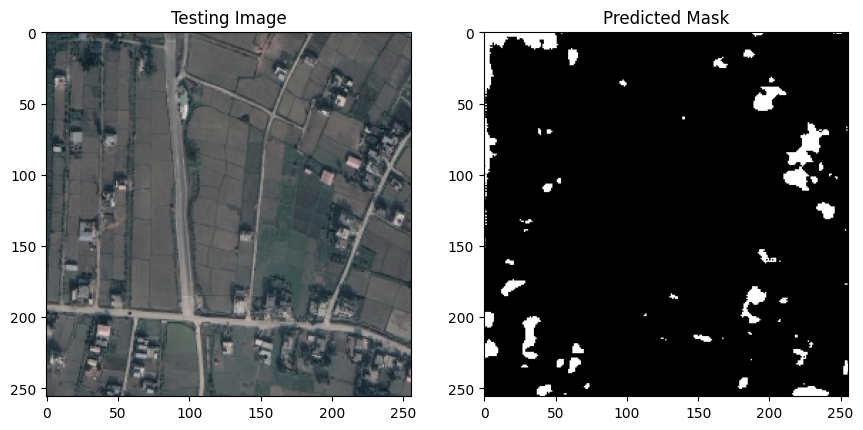

In [ ]:
threshold = 0.8
predicted_mask = (predictions > threshold).astype(np.uint8)

predicted_mask = predicted_mask[0, :, :, 0]

image = image_prepr[0].reshape((256, 256, 3))

predicted_mask = 1 - predicted_mask

plt.figure(figsize=(16, 12))
plt.subplot(235)
plt.title('Testing Image')
plt.imshow(image)
plt.subplot(236)
plt.title('Predicted Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.show()